In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import iqr
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import os

In [18]:
# %%
print("--- Début du Nettoyage des Données (Tâche 2) ---")

# 1. Chargement du fichier brut
df = pd.read_csv("network_traffic_raw.csv")
rows_before = len(df)

# 2. Correction des Valeurs Invalides/Négatives (Remplacer par NaN)
numeric_cols_to_check = ['FlowDuration', 'TotalPackets', 'TotalBytes', 'PacketRate']
for col in numeric_cols_to_check:
    # Utilisation de .loc pour modifier le DataFrame original df
    df.loc[df[col] < 0, col] = np.nan 

# 3. Standardisation de la colonne 'Protocol'
df['Protocol'] = df['Protocol'].str.strip().str.lower()
df['Protocol'] = df['Protocol'].replace({'t.c.p': 'tcp', 'u.d.p': 'udp'})

# 4. Suppression des lignes avec valeurs manquantes (pour un dataset complet)
# CORRECTION MAJEURE: Utiliser .copy() pour garantir que df_clean est une copie indépendante et modifiable.
df_clean = df.dropna().copy() 
rows_after_drop = len(df_clean)
print(f"Lignes supprimées (NaN/Négatives) : {rows_before - rows_after_drop}")
print(f"Lignes conservées : {rows_after_drop}")

# 5. Traitement des Valeurs Aberrantes (Outliers) par Plafonnement (Capping IQR)
outlier_cols = ['FlowDuration', 'TotalPackets', 'TotalBytes', 'ByteRate', 'PacketRate']
for col in outlier_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR_val = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR_val
    
    # CORRECTION: Utiliser .loc pour effectuer le plafonnement de manière sûre 
    # et supprimer le SettingWithCopyWarning.
    df_clean.loc[df_clean[col] > upper_bound, col] = upper_bound

# Sauvegarder le fichier nettoyé 
df_clean.to_csv("network_traffic_clean.csv", index=False)
print("Fichier 'network_traffic_clean.csv' créé (Nettoyage Tâche 2 terminé).")

--- Début du Nettoyage des Données (Tâche 2) ---
Lignes supprimées (NaN/Négatives) : 317
Lignes conservées : 1508
Fichier 'network_traffic_clean.csv' créé (Nettoyage Tâche 2 terminé).


In [19]:
# Recharger le fichier nettoyé (Tâche 2 terminée)
df_clean = pd.read_csv("network_traffic_clean.csv")

# ----------------------------------------------------------------
# PHASE 3: MISE À L'ÉCHELLE POUR K-MEANS (Tâche 4)
# ----------------------------------------------------------------

print("--- Début de la Préparation K-Means (Tâche 4) ---")

# 1. Sélection et Encodage des Caractéristiques
# a. Exclure 'FlowID' et préparer les features
df_features = df_clean.drop(columns=['FlowID'])

# b. Encodage One-Hot de la colonne 'Protocol' (convertit TCP/UDP en 0 et 1)
df_encoded = pd.get_dummies(df_features, columns=['Protocol'], drop_first=False)

# Retirer les colonnes inutiles 'Protocol_?' et 'Protocol_unknown' (si elles existent)
df_encoded = df_encoded.drop(columns=['Protocol_?', 'Protocol_unknown'], errors='ignore')

# 2. Mise à l'Échelle (Scaling) des Caractéristiques
# L'objet de cette étape est de mettre la Moyenne à 0 et l'Écart-Type à 1 (StandardScaler)
scaler = StandardScaler()
df_scaled_data = scaler.fit_transform(df_encoded)

# Reconversion en DataFrame
df_scaled = pd.DataFrame(df_scaled_data, columns=df_encoded.columns)

# 3. Vérification et Sauvegarde du fichier final
print(f"Nombre final de caractéristiques normalisées : {len(df_scaled.columns)}")
print("Vérification des statistiques (Moyenne ≈ 0, Écart-type ≈ 1) :")
print(df_scaled[['FlowDuration', 'TotalBytes', 'PacketRate']].describe().loc[['mean', 'std']].to_markdown(numalign="left", stralign="left", floatfmt=".2f"))

# Sauvegarder le jeu de données final, prêt pour K-Means



df_scaled.to_csv("network_traffic_scaled.csv", index=False)

print("\nFichier 'network_traffic_scaled.csv' créé (Préparation Tâche 4 terminée).")

--- Début de la Préparation K-Means (Tâche 4) ---
Nombre final de caractéristiques normalisées : 18
Vérification des statistiques (Moyenne ≈ 0, Écart-type ≈ 1) :
|      | FlowDuration   | TotalBytes   | PacketRate   |
|:-----|:---------------|:-------------|:-------------|
| mean | 0.00           | 0.00         | 0.00         |
| std  | 1.00           | 1.00         | 1.00         |

Fichier 'network_traffic_scaled.csv' créé (Préparation Tâche 4 terminée).


--- Début de la Tâche 5 : Détermination du K Optimal (Méthode du Coude) ---

WCSS (Somme des Carrés Intra-Clusters) pour K = 2 à 10 :
K=2: 20399.92
K=3: 16128.03
K=4: 14748.20
K=5: 13209.19
K=6: 9936.23
K=7: 9377.29
K=8: 8136.14
K=9: 7352.58
K=10: 6933.40

Exécution de la Tâche 5 terminée. Le graphique 'courbe_du_coude.png' a été sauvegardé.


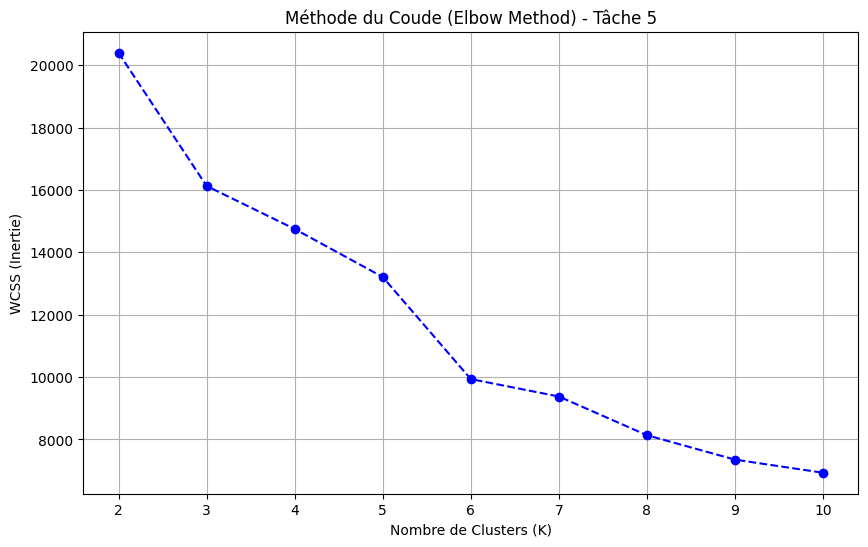

In [20]:

# PHASE 4: DÉTERMINATION DU K OPTIMAL (Tâche 5)
# ----------------------------------------------------------------

print("--- Début de la Tâche 5 : Détermination du K Optimal (Méthode du Coude) ---")

# 1. Chargement des données mises à l'échelle
df_scaled = pd.read_csv("network_traffic_scaled.csv")

# 2. Préparation du modèle et du conteneur WCSS
wcss = []
k_range = range(2, 11) # Tester K de 2 à 10

# 3. Calcul de la WCSS pour chaque K
for k in k_range:
    # Initialisation avec random_state pour la reproductibilité
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') 
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_) # 'inertia_' est le WCSS

# 4. Affichage du WCSS et de la Courbe du Coude

print("\nWCSS (Somme des Carrés Intra-Clusters) pour K = 2 à 10 :")
for k, score in zip(k_range, wcss):
    print(f"K={k}: {score:.2f}")

# Création et Sauvegarde de la visualisation (Courbe du Coude)
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--', color='blue')
plt.title("Méthode du Coude (Elbow Method) - Tâche 5")
plt.xlabel("Nombre de Clusters (K)")
plt.ylabel("WCSS (Inertie)")
plt.xticks(k_range)
plt.grid(True)
plt.savefig("courbe_du_coude.png")

print("\nExécution de la Tâche 5 terminée. Le graphique 'courbe_du_coude.png' a été sauvegardé.")

In [21]:

print("--- Début de la Tâche 6 : K-Means avec K=6 ---")

# 1. Chargement des données brutes propres et des données normalisées
df_clean = pd.read_csv("network_traffic_clean.csv")
df_scaled = pd.read_csv("network_traffic_scaled.csv")

K_OPTIMAL = 3

kmeans_final = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init='auto')
cluster_labels = kmeans_final.fit_predict(df_scaled)

# 3. Attribuer les labels aux données non-mises à l'échelle
df_clean['Cluster'] = cluster_labels

# 4. Sauvegarder le résultat du clustering
df_clean.to_csv("network_traffic_clustered.csv", index=False)

print(f"Clustering Terminé. Les étiquettes de cluster (0 à {K_OPTIMAL-1}) ont été ajoutées.")
print("Fichier 'network_traffic_clustered.csv' créé pour l'interprétation (Tâche 8).")

--- Début de la Tâche 6 : K-Means avec K=6 ---
Clustering Terminé. Les étiquettes de cluster (0 à 2) ont été ajoutées.
Fichier 'network_traffic_clustered.csv' créé pour l'interprétation (Tâche 8).


In [22]:

# ----------------------------------------------------------------
# PHASE 5: PROFILAGE ET INTERPRÉTATION (Tâche 8)
# ----------------------------------------------------------------

print("--- Début de la Tâche 8 : Profilage des Clusters ---")

# 1. Chargement des données clustérisées (avec les labels de cluster)
df_clustered = pd.read_csv("network_traffic_clustered.csv")

# 2. Calcul des caractéristiques moyennes par cluster
# Nous utilisons la moyenne et la médiane pour les colonnes numériques clés
cluster_summary = df_clustered.groupby('Cluster')[['FlowDuration', 'TotalPackets', 'TotalBytes', 
                                                     'PacketRate', 'ByteRate', 'Port', 
                                                     'AvgPacketSize', 'InterArrivalTime']].mean()

# Afficher les caractéristiques numériques moyennes
print("\n--- Statistiques Moyennes des Clusters (Profil Numérique) ---")
print(cluster_summary.to_markdown(numalign="left", stralign="left", floatfmt=".2f"))

# 3. Analyser les protocoles dominants
print("\n--- Protocoles Dominants par Cluster ---")
protocol_distribution = df_clustered.groupby('Cluster')['Protocol'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()

# Afficher le protocole le plus fréquent pour chaque cluster
dominant_protocols = protocol_distribution.loc[
    protocol_distribution.groupby('Cluster')['Percent'].idxmax()
]
print(dominant_protocols.to_markdown(numalign="left", stralign="left", floatfmt=".1f"))



--- Début de la Tâche 8 : Profilage des Clusters ---

--- Statistiques Moyennes des Clusters (Profil Numérique) ---
| Cluster   | FlowDuration   | TotalPackets   | TotalBytes   | PacketRate   | ByteRate   | Port     | AvgPacketSize   | InterArrivalTime   |
|:----------|:---------------|:---------------|:-------------|:-------------|:-----------|:---------|:----------------|:-------------------|
| 0         | 1249.32        | 35498.14       | 324821163.35 | 358.94       | 8087075.76 | 1406.49  | 1394.73         | 0.02               |
| 1         | 13.31          | 70.57          | 1026455.36   | 18.53        | 19971.44   | 1542.32  | 386.76          | 1.10               |
| 2         | 2747.91        | 94660.08       | 24513441.83  | 126.98       | 269234.15  | 34589.68 | 297.83          | 0.03               |

--- Protocoles Dominants par Cluster ---
|    | Cluster   | Protocol   | Percent   |
|:---|:----------|:-----------|:----------|
| 0  | 0         | tcp        | 99.7      |
| 3  

In [23]:

# =================================================================
# PHASE 6: ÉVALUATION DES CLUSTERS (Tâche 7)
# =================================================================

print("\n--- Début de la Tâche 7 : Évaluation des Clusters ---")

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

X = df_scaled  # données normalisées
labels = cluster_labels  # labels K-Means K=6

sil_score = silhouette_score(X, labels)
db_score = davies_bouldin_score(X, labels)
ch_score = calinski_harabasz_score(X, labels)

print(f"Silhouette Score : {sil_score:.4f}")
print(f"Davies-Bouldin Index : {db_score:.4f}")
print(f"Calinski-Harabasz Index : {ch_score:.4f}")


--- Début de la Tâche 7 : Évaluation des Clusters ---
Silhouette Score : 0.3402
Davies-Bouldin Index : 1.2324
Calinski-Harabasz Index : 513.9820


In [24]:

# =================================================================
# PHASE 7: VISUALISATION DES CLUSTERS AVEC PCA (Tâche 6 suite)
# =================================================================

print("\n--- Visualisation des Clusters avec PCA ---")

from sklearn.decomposition import PCA

# Création du dossier PCA
import os
os.makedirs("plots_pca", exist_ok=True)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, s=10)
plt.title("Visualisation des Clusters en 2D avec PCA (K=6)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.savefig("plots_pca/visualisation_pca_clusters.png")
plt.close()

print("Graphique PCA sauvegardé dans 'plots_pca/'")


--- Visualisation des Clusters avec PCA ---
Graphique PCA sauvegardé dans 'plots_pca/'


In [25]:

# =================================================================
# PHASE 8: ANALYSE EXPLORATOIRE DES DONNÉES (Tâche 3)
# =================================================================

print("\n--- Début de la Tâche 3 : Analyse Exploratoire des Données ---")

import seaborn as sns

# Création des dossiers
os.makedirs("plots_hist", exist_ok=True)
os.makedirs("plots_box", exist_ok=True)
os.makedirs("plots_heatmap", exist_ok=True)

numeric_cols = [
    'FlowDuration', 'TotalPackets', 'TotalBytes',
    'PacketRate', 'ByteRate', 'AvgPacketSize', 'InterArrivalTime'
]

# 1. Histogrammes
for col in numeric_cols:
    plt.figure(figsize=(7, 4))
    sns.histplot(df_clean[col], kde=True)
    plt.title(f"Distribution de {col}")
    plt.savefig(f"plots_hist/hist_{col}.png")
    plt.close()



--- Début de la Tâche 3 : Analyse Exploratoire des Données ---


In [26]:

# 2. Boxplots
for col in numeric_cols:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x=df_clean[col])
    plt.title(f"Boxplot de {col}")
    plt.savefig(f"plots_box/box_{col}.png")
    plt.close()

In [27]:

# 3. Heatmap de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de Corrélation (Tâche 3)")
plt.savefig("plots_heatmap/heatmap_correlation.png")
plt.close()

print("Histogrammes, boxplots et heatmap enregistrés dans leurs dossiers respectifs.")

Histogrammes, boxplots et heatmap enregistrés dans leurs dossiers respectifs.


In [28]:
 
# PHASE 9: VISUALISATION DES CLUSTERS AVEC t-SNE 3D (Ajout)
# =================================================================

print("\n--- Début de la Tâche 6 (suite) : Visualisation 3D avec t-SNE ---")

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import os

# NOTE: Les variables df_scaled, cluster_labels et K_OPTIMAL sont supposées définies
# K_OPTIMAL doit être = 6 pour cette visualisation

# Création du dossier pour la visualisation t-SNE
os.makedirs("plots_tsne", exist_ok=True)

# Application de t-SNE pour obtenir 3 dimensions
tsne = TSNE(n_components=3, random_state=42, n_jobs=-1, perplexity=30, init='pca', learning_rate='auto') 
tsne_data_3d = tsne.fit_transform(df_scaled)

# Création du graphique 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d') # Configuration 3D

# Les trois axes sont les trois dimensions t-SNE
scatter = ax.scatter(tsne_data_3d[:, 0], # t-SNE Dimension 1
                     tsne_data_3d[:, 1], # t-SNE Dimension 2
                     tsne_data_3d[:, 2], # t-SNE Dimension 3
                     c=cluster_labels, # Utilise les labels K=6
                     cmap='viridis', # Colormap pour distinguer les clusters
                     s=20)

# Ajout d'une légende des couleurs (facultatif mais recommandé pour K=6)
legend1 = ax.legend(*scatter.legend_elements(), 
                    title="Clusters",
                    bbox_to_anchor=(1.05, 1), loc='upper left')
ax.add_artist(legend1)

ax.set_title(f"Visualisation des Clusters en 3D avec t-SNE (K={K_OPTIMAL})")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3") 

# Sauvegarde du fichier
output_filename = f"plots_tsne/visualisation_tsne_3d_clusters_k{K_OPTIMAL}.png"
plt.savefig(output_filename)
plt.close()

print(f"Visualisation 3D sauvegardée : {output_filename}")


--- Début de la Tâche 6 (suite) : Visualisation 3D avec t-SNE ---
Visualisation 3D sauvegardée : plots_tsne/visualisation_tsne_3d_clusters_k3.png
